# Training a model using visualized tabular data

In [1]:
# !pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

In [2]:
from torchsampler import ImbalancedDatasetSampler

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import timm

import os
from pathlib import Path
import json

from tqdm import tqdm

import random

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(24)

Custom metrics.

In [5]:
def macro_averaged_mean_absolute_error(y_true, y_pred):
    labels = unique_labels(y_true, y_pred)
    mae = []
    for possible_class in labels:
        indices = np.flatnonzero(y_true == possible_class)
        mae.append(metrics.mean_absolute_error(y_true[indices], y_pred[indices],))

    return np.sum(mae) / len(mae)

def calculate_metrics(y_true, y_pred):    
    y_true_arr = np.array(y_true)
    y_pred_arr = np.array(y_pred)

    if np.in1d(y_pred_arr, y_true_arr, invert=True).sum() > 0:
        raise ValueError("There are non-existent labels in predictions")

    weights = np.array([1.0, 1.0, 1.5, 1.5, 1.5])
    recall_multi = metrics.recall_score(y_true_arr, y_pred_arr, average=None)
    weighted_accuracy = np.sum(np.multiply(recall_multi, weights)) / np.sum(weights)
    mamae = macro_averaged_mean_absolute_error(y_true_arr, y_pred_arr)
    return weighted_accuracy - 0.25 * mamae

Upload visualized tabular data prepared in ods_pic.ipynb.

In [6]:
targets_train = pd.read_csv("data_train/targets_train.csv", index_col=0)
train_dir = 'img_tensors'
test_dir = 'test_img_tensors'

Сheck that the images can be rendered correctly.

In [7]:
image = torch.load('{}/{}'.format(train_dir, os.listdir(train_dir)[0]))

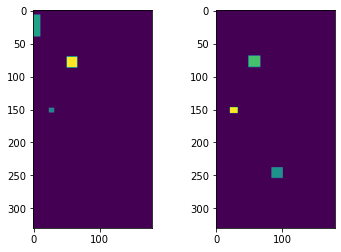

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image[26]);
ax2.imshow(image[27]);

Split the data to train (70%) and validation (30%) sets.

In [9]:
train_rows, valid_rows = train_test_split(targets_train, 
                                          test_size=0.3, 
                                          random_state=24, 
                                          shuffle=True, 
                                          stratify=targets_train)

Make sure both sets contain a data of each class.

In [10]:
train_rows.value_counts()

BiRads
2         1693
1         1043
3           73
4           31
5            4
dtype: int64

In [11]:
valid_rows.value_counts()

BiRads
2         726
1         447
3          31
4          13
5           2
dtype: int64

In [12]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, annotations_file=None):
        self.filenames = os.listdir(img_dir)
        self.img_dir = img_dir
        self.annotations_file = annotations_file

    def __len__(self):
        if self.annotations_file is not None:
            return len(self.annotations_file['BiRads'])
        else:
            return len(self.filenames)

    def __getitem__(self, idx):
        if self.annotations_file is not None:         
            filename = self.annotations_file.iloc[idx].name
            label = self.annotations_file.loc[filename][0] - 1
        else:
            filename = self.filenames[idx][:-3]
        
        image = torch.load('{}/{}.pt'.format(self.img_dir, filename))
        
        if self.annotations_file is not None:            
            return image, label
        else:
            return image, filename
        
    def get_labels(self):
        return self.annotations_file["BiRads"].to_numpy() - 1

Define aug() function to create more data and avoid overfitting. By default it sets random 5 pixels to zero with 0.5 probability.

It's only applied to channels starting from 3rd as first 3 channels are tissue_density_predicted, cancer_probability_predicted and laterality, which can't be changed.

In [13]:
def aug(batch_tensor, p=0.5, num_changing=5):
    pp = torch.rand(1)
    if p >= pp:
        zero_chan = ((batch_tensor.shape[1] - 3) * torch.rand(num_changing) + 3).long()
        batch_tensor[:, zero_chan, :, :] = 0.0
    return batch_tensor

In [14]:
train_data = CustomImageDataset(train_dir, train_rows)
valid_data = CustomImageDataset(train_dir, valid_rows)

In [15]:
batch_size = 25
train_dataloader = DataLoader(train_data, 
                              sampler=ImbalancedDatasetSampler(train_data),
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=2)
valid_dataloader = DataLoader(valid_data, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=2)

Using ResNet for training. The model inputs are images containing 46 channels, corresponding to 46 features. The number of outputs corresponds to the 5 Bi-Rads classes to be predicted.

In [16]:
model = timm.create_model("resnet18", num_classes=5, in_chans=46, pretrained=False)

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

The folowing is a training function. It saves the best (by custom_metrics) model as best_model.pt.

In [18]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    best_metric = -1000.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()
                scheduler.step()        
            else:
                dataloader = valid_dataloader
                model.eval()

            running_loss, running_acc = 0.0, 0.0
            y_pred, y_true = [], []
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                if phase == 'train':
                    inputs = aug(inputs, p=0.9, num_changing=20)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
                
                y_true.extend(labels.data.cpu().view(-1).numpy())
                y_pred.extend(preds_class.cpu().numpy())
                                
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            epoch_cust_metr = calculate_metrics(y_true, y_pred)
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_accuracy_history.append(epoch_acc)
                train_custom_metric_history.append(epoch_cust_metr)
            else:
                if epoch_cust_metr > best_metric:
                    best_metric = epoch_cust_metr
                    torch.save(model.state_dict(), "/kaggle/working/best_model.pt")
                val_loss_history.append(epoch_loss)
                val_accuracy_history.append(epoch_acc)
                val_custom_metric_history.append(epoch_cust_metr)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            print('Custom metric: ', epoch_cust_metr)
    return model

The lists below will be filled out after training for further visualization of statistics.

In [19]:
train_accuracy_history = []
train_loss_history = []
train_custom_metric_history = []
val_accuracy_history = []
val_loss_history = []
val_custom_metric_history = []

In [20]:
train_model(model, loss, optimizer, scheduler, num_epochs=30);

In [21]:
plt.plot(train_loss_history, label='train_loss')
plt.plot(val_loss_history, label='val_loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')

In [22]:
plt.plot(train_accuracy_history, label='train_accuracy')
plt.plot(val_accuracy_history, label='val_accuracy')
plt.legend(loc='lower right')
plt.xlabel('epoch')

In [23]:
plt.plot(train_custom_metric_history, label='train_custom_metric')
plt.plot(val_custom_metric_history, label='val_custom_metric')
plt.legend(loc='upper left')
plt.xlabel('epoch')

Load the best model saved before.

In [25]:
# model.load_state_dict(torch.load('best_model.pt'))
# model = model.to(device)

After the model is trained, preparing submission file.

In [26]:
test_data = CustomImageDataset(test_dir)
test_dataloader = DataLoader(test_data, 
                             batch_size=batch_size, 
                             shuffle=True, 
                             num_workers=2)

In [ ]:
test_predictions = []
test_img = []

model.eval()

for inputs, filename in tqdm(test_dataloader):
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
        preds_class = preds.argmax(dim=1)
    test_predictions.append(preds_class.cpu().numpy())
    test_img.extend(filename)
test_predictions = np.concatenate(test_predictions)

In [ ]:
unique, counts = np.unique(test_predictions + 1, return_counts=True)
print(np.asarray((unique, counts)).T)

In [29]:
submission_df = pd.DataFrame.from_dict({'id': test_img, 'BiRads': test_predictions + 1})

In [30]:
submission_df.head()

,id,BiRads
0,0a0fafbb-741c-4ce4-8858-869fc1962f7d,1
1,0a3bdee6-7be6-401f-93a5-62060fa6d7d1,3
2,0a70bed8-2839-4a1e-beb1-783fc3e61af8,3
3,0a8e4353-f070-46fd-99b8-8f9dd78ee4fa,1
4,0a673d69-7ff1-42c8-8063-ea01eb905d38,4
